<a href="https://colab.research.google.com/github/v-chns/ristek-final-project/blob/main/data-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Preparation
- Import library yang dibutuhkan
- Membaca file CSV yang sudah diupload ke session storage (Customer Reviews - Kopi Kenangan.csv), atau hubungkan google colab dengan google drive

In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace, col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# Link to CSV: https://drive.google.com/file/d/1QhFDSPyAUkx9lIbkx3VKZJaLl0FNibsQ/view?usp=drive_link

# Read CSV
spark = SparkSession.builder.getOrCreate()
dataset = spark.read.option("inferSchema", "true").csv("/content/Customer Reviews - Kopi Kenangan - Google Maps Reviews.csv", header = True)

dataset.show()

+----+---------+-------+--------------------+---------------+-----------+-------------+---------+-----+--------------------+---------+-----------+--------------------+-----------+----------+-------------+
| _c0|review_id| branch|       reviewer_name|reviewer_gender|review_date|review_counts|   rating|likes|             content|sentiment|review_tone|                tags|about_place|about_food|about_service|
+----+---------+-------+--------------------+---------------+-----------+-------------+---------+-----+--------------------+---------+-----------+--------------------+-----------+----------+-------------+
|B001|        1|Bandung|mEjiGOs2PtuNwnuzrOuX|         female|   8/7/2022|    83 ulasan|5 bintang| null|Kalau pas lagi ke...| Positive|  satisfied|  [minuman, rasanya]|          0|         1|            0|
|B001|        2|Bandung|mEjiMZMUZCWPvbqS47Ab|         female|   9/3/2022|   133 ulasan|5 bintang| null|Jadi kemarin aku ...| Positive|  satisfied|[ parkiran, tempa...|          1| 

# Step 2: Pre-Processing & Feature Engineering
- Menghilangkan null values dan kolom yang tidak diperlukan
- Convert data non-numerik menjadi numerik (jika dibutuhkan)

In [ ]:
# Feature selection (memilih fitur fitur yang dianggap penting)
# Hapus reviewer_name, branch_id, review_id, dan sepertinya nama kolom branch_idnya keubah jadi _c0:')
dataset = dataset.drop('reviewer_name', 'branch_id', 'review_id', '_c0')

# Pada fitur 'likes', jika tidak ada sama sekali maka kosong, sehingga nanti bisa terhapus, jadi ubah yang kosong menjadi 0
dataset = dataset.withColumn("likes", when((dataset["likes"] == "") | dataset["likes"].isNull(), 0).otherwise(col("likes")))
# Drop null/missing values
dataset = dataset.na.drop()


# Turn dataset to Pandas' dataframe to see if there are any null values
df = dataset.toPandas()
print(df.info())

dataset.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   branch           710 non-null    object
 1   reviewer_gender  710 non-null    object
 2   review_date      710 non-null    object
 3   review_counts    710 non-null    object
 4   rating           710 non-null    object
 5   likes            710 non-null    object
 6   content          710 non-null    object
 7   sentiment        710 non-null    object
 8   review_tone      710 non-null    object
 9   tags             710 non-null    object
 10  about_place      710 non-null    int32 
 11  about_food       710 non-null    int32 
 12  about_service    710 non-null    int32 
dtypes: int32(3), object(10)
memory usage: 63.9+ KB
None
+-------+---------------+-----------+-------------+---------+-----+--------------------+---------+-----------+--------------------+-----------+----------+---------

In [ ]:
# Mengubah format kolom 'rating'
dataset = dataset.withColumn("rating", regexp_replace(col("rating"), " bintang", "").cast("int"))

# Lakukan yang sama dengan review_counts
dataset = dataset.withColumn("review_counts", regexp_replace(col("review_counts"), " ulasan", "").cast("int"))

dataset.show()

+-------+---------------+-----------+-------------+------+-----+--------------------+---------+-----------+--------------------+-----------+----------+-------------+
| branch|reviewer_gender|review_date|review_counts|rating|likes|             content|sentiment|review_tone|                tags|about_place|about_food|about_service|
+-------+---------------+-----------+-------------+------+-----+--------------------+---------+-----------+--------------------+-----------+----------+-------------+
|Bandung|         female|   8/7/2022|           83|     5|    0|Kalau pas lagi ke...| Positive|  satisfied|  [minuman, rasanya]|          0|         1|            0|
|Bandung|         female|   9/3/2022|          133|     5|    0|Jadi kemarin aku ...| Positive|  satisfied|[ parkiran, tempa...|          1|         0|            1|
|Bandung|           male| 10/20/2019|           24|     1|    0|Boba nya keras ga...| Negative|  disgusted|[minuman, pesanan...|          0|         1|            0|
|Ban

In [ ]:
# Look at unique values to see if there are anything to fix
dataset.select("review_tone").distinct().show()
dataset.select("sentiment").distinct().show()
dataset.select("branch").distinct().show()
dataset.select("reviewer_gender").distinct().show()
dataset.select("rating").distinct().show()

+------------+
| review_tone|
+------------+
|      Happy.|
|unsatisfied.|
|     Enjoyed|
| unsatisfied|
|         sad|
|     neutral|
|    disliked|
|   Satisfied|
|   disgusted|
|        fear|
|     Neutral|
|   Disgusted|
|   satisfied|
|    Question|
|       happy|
|   delighted|
|     unhappy|
|       Happy|
|     enjoyed|
|    neutral.|
+------------+

+---------+
|sentiment|
+---------+
| Positive|
|  Neutral|
| Negative|
+---------+

+-----------+
|     branch|
+-----------+
|    Jakarta|
|   Semarang|
|Kota Bekasi|
|   Surabaya|
|    Bandung|
+-----------+

+---------------+
|reviewer_gender|
+---------------+
|         female|
|           male|
+---------------+

+------+
|rating|
+------+
|     1|
|     3|
|     5|
|     4|
|     2|
+------+



In [ ]:
# Create the function (ini mengikuti notebook para TAs🙏🏻)
def tone_process(data):
    try:
        # TODO: write program to clean "review_tone" column
        # Step 1: Remove leading and trailing whitespace
        data = data.strip()

        # Step 2: Remove punctuation. In this case, period "."
        data = data.replace(".","")

        # Optional
        data = data.title()

        # Return the cleaned data
        return data
    except:
        return data

df = dataset.toPandas()
df['review_tone'] = df['review_tone'].apply(tone_process)
set(df['review_tone'])

{'Delighted',
 'Disgusted',
 'Disliked',
 'Enjoyed',
 'Fear',
 'Happy',
 'Neutral',
 'Question',
 'Sad',
 'Satisfied',
 'Unhappy',
 'Unsatisfied'}

In [ ]:
# Save file to csv
df.to_csv('file_cleaned.csv',index=False)

# Tags (Optional)

In [ ]:
# Using RegEx
import re
def get_tags(data):
    try:
        data = data.strip()
        data = data.split(',')
        data = [re.findall("\w+",x)[0] for x in data]
        return data
    except:
        return [np.nan] # Silakan ubah sesuai keinginan/logic kalian

all_tags = list()
for tag in df['tags']:
    x = get_tags(tag)
    all_tags += x

extracted = pd.Series(all_tags).value_counts()

data = pd.DataFrame({
    'tag':extracted.index,
    'count':extracted.values
})
data

,tag,count
0,tempat,326
1,minuman,182
2,pelayanan,153
3,rasa,116
4,suasana,71
5,parkiran,54
6,pegawai,53
7,promo,27
8,keluhan,25
9,pesanan,24


# Visualization (Optional)
*   Hanya digunakan untuk melihat secara cepat



<ipython-input-52-30f65226c740>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_heatmap.corr()


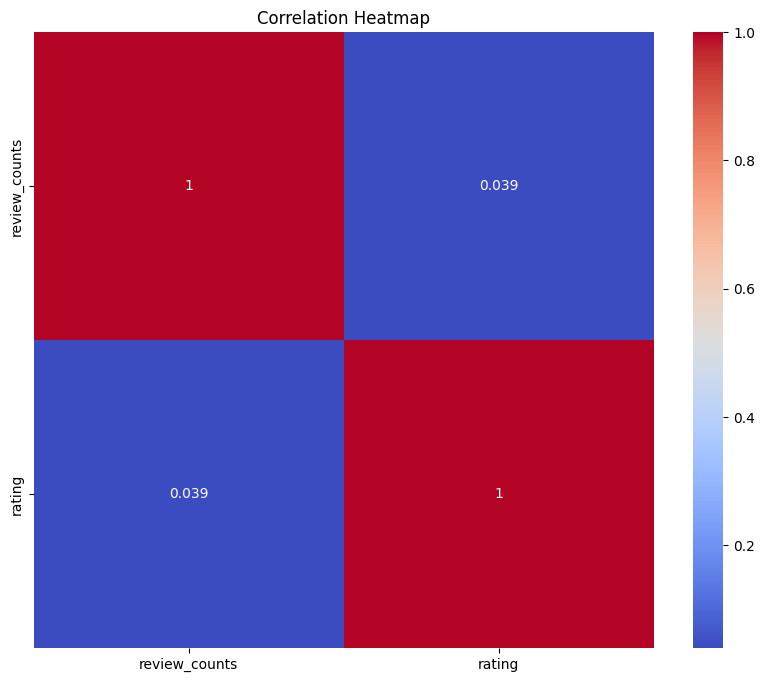

In [ ]:
# Heat map
# Buat matrix yang menunjukan seberapa kuat hubungan antar fitur
df_heatmap = df[["review_counts", "rating", "likes"]]
correlation_matrix = df_heatmap.corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

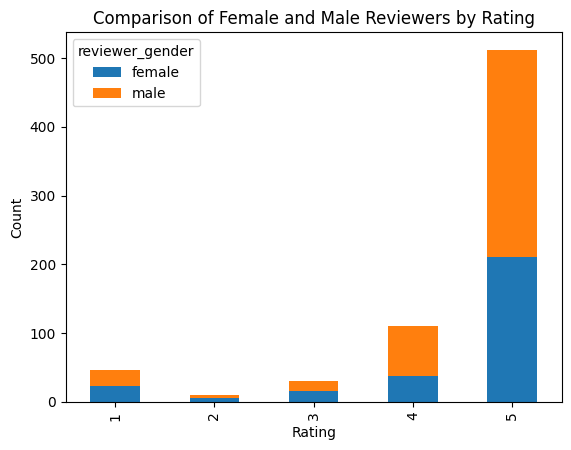

In [ ]:
grouped_data = df.groupby(["rating", "reviewer_gender"]).size().unstack(fill_value=0)

# Create a bar plot
ax = grouped_data.plot(kind="bar", stacked=True)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Comparison of Female and Male Reviewers by Rating")

# Show the plot
plt.show()


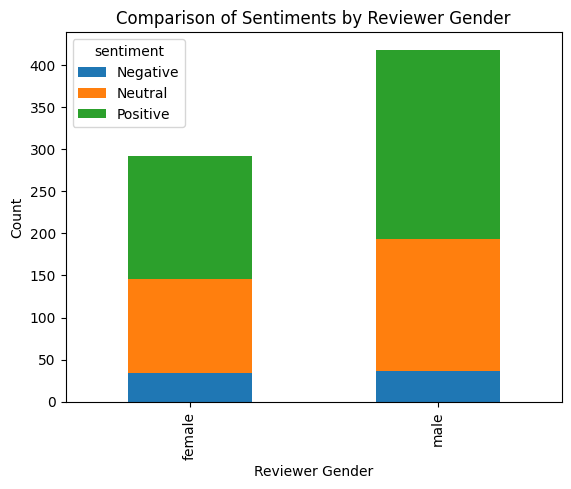

In [ ]:
grouped_data = df.groupby(["reviewer_gender", "sentiment"]).size().unstack(fill_value=0)

ax = grouped_data.plot(kind="bar", stacked=True)

plt.xlabel("Reviewer Gender")
plt.ylabel("Count")
plt.title("Comparison of Sentiments by Reviewer Gender")

plt.show()